Setup & Data Download

In [1]:
from google.colab import files
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

print("Please upload the 'Indian_pines_corrected.mat' file:")
uploaded = files.upload()

# Get the name of the uploaded file(s)
for fn in uploaded.keys():
    print(f'User uploaded file "{fn}"')
    # Optionally, you can store the filename to use later
    uploaded_filename = fn

# Verify the file is in the current directory
if 'uploaded_filename' in locals() and os.path.exists(uploaded_filename):
    print(f"File '{uploaded_filename}' successfully uploaded and is accessible.")
    # If the user uploads the expected file, update the file_path variable
    if uploaded_filename == 'Indian_pines_corrected.mat':
        file_path = 'Indian_pines_corrected.mat'
        print("file_path variable updated for HSIImageProcessor.")
    else:
        print(f"Warning: Uploaded file name '{uploaded_filename}' does not match expected 'Indian_pines_corrected.mat'. Please adjust `file_path` in the main execution block accordingly.")
else:
    print("No file was uploaded or file not found after upload.")

Please upload the 'Indian_pines_corrected.mat' file:


Saving Indian_pines_corrected.mat to Indian_pines_corrected (4).mat
User uploaded file "Indian_pines_corrected (4).mat"
File 'Indian_pines_corrected (4).mat' successfully uploaded and is accessible.


Data Loading & Helper Functions

In [2]:
# Cell 2: Data Loading & Normalization Helper
def load_indian_pines():
    try:
        data = scipy.io.loadmat('Indian_pines_corrected.mat')
        # Key is usually 'indian_pines_corrected'
        cube = data['indian_pines_corrected']
        print(f"Hyperspectral Cube Loaded. Shape: {cube.shape} (Height x Width x Bands)")
        return cube
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def get_band_image(cube, band_index):
    """
    Extracts a band and normalizes it to 0-255 for processing.
    """
    band = cube[:, :, band_index]

    # Normalize to 0-255 (Min-Max Scaling)
    img_min = np.min(band)
    img_max = np.max(band)

    if img_max - img_min == 0:
        return band.astype(np.uint8)

    # (pixel - min) / (max - min) * 255
    normalized = (band - img_min) / (img_max - img_min) * 255
    return normalized.astype(np.uint8)

# Load the data globally
hsi_cube = load_indian_pines()
# Select Band 100 as our test image
original_img = get_band_image(hsi_cube, 100)

Hyperspectral Cube Loaded. Shape: (145, 145, 200) (Height x Width x Bands)


Point Processing Algorithms

In [3]:
# Cell 3: Point Processing Algorithms (From Scratch)

def log_transform(image):
    # Formula: s = c * log(1 + r)
    # c is a scaling constant to map back to 0-255
    c = 255 / np.log(1 + np.max(image))
    transformed = c * np.log(1 + image)
    return transformed.astype(np.uint8)

def gamma_correction(image, gamma=1.0):
    # Formula: s = c * r^gamma
    # Normalize to 0-1 first for math stability
    img_float = image / 255.0
    corrected = np.power(img_float, gamma)
    # Scale back
    return (corrected * 255).astype(np.uint8)

def contrast_stretching(image):
    # Formula: (pixel - min) * (255 / (max - min))
    # This spreads the intensity values over the full 0-255 range
    img_min = np.min(image)
    img_max = np.max(image)

    if img_max - img_min == 0: return image

    stretched = (image - img_min) * (255.0 / (img_max - img_min))
    return stretched.astype(np.uint8)

Histogram Equalization

In [4]:
# Cell 4: Histogram Equalization (From Scratch)

def histogram_equalization(image):
    height, width = image.shape
    total_pixels = height * width

    # 1. Calculate Histogram (Frequency of each pixel value 0-255)
    # We start with an array of zeros
    hist = np.zeros(256, dtype=int)

    # Flatten image to iterate faster or use unique
    flat = image.flatten()
    for pixel in flat:
        hist[pixel] += 1

    # 2. Calculate Cumulative Distribution Function (CDF)
    cdf = np.zeros(256)
    cdf[0] = hist[0]
    for i in range(1, 256):
        cdf[i] = cdf[i-1] + hist[i]

    # 3. Normalize CDF to create the mapping function
    # Mask masked values (0) so they don't affect min calculation
    cdf_min = np.min(cdf[cdf > 0])

    # Formula: round( (cdf(v) - cdf_min) / (total - cdf_min) * 255 )
    transfer_map = np.round((cdf - cdf_min) / (total_pixels - cdf_min) * 255)

    # Ensure values are valid uint8
    transfer_map = np.clip(transfer_map, 0, 255).astype(np.uint8)

    # 4. Map original pixels to new values
    # This acts as a lookup: image value 'x' is replaced by 'transfer_map[x]'
    equalized_img = transfer_map[image]

    return equalized_img

Spatial Filters (Convolution)

In [5]:
# Cell 5: Convolution and Spatial Filters (From Scratch)

def convolve2d(image, kernel):
    """
    Basic sliding window convolution implementation.
    """
    k_h, k_w = kernel.shape
    h, w = image.shape

    pad_h = k_h // 2
    pad_w = k_w // 2

    # Create padded image (zero padding)
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')

    output = np.zeros_like(image, dtype=float)

    # Sliding window
    for i in range(h):
        for j in range(w):
            # Extract region of interest
            region = padded[i:i+k_h, j:j+k_w]
            # Element-wise multiply and sum
            output[i, j] = np.sum(region * kernel)

    return output

def mean_filter(image, size=3):
    # Create a kernel where every value is 1/(size^2)
    kernel = np.ones((size, size)) / (size**2)
    result = convolve2d(image, kernel)
    return result.astype(np.uint8)

def sobel_edge_detection(image):
    # Sobel Kernels
    # Gx: Vertical edges
    Gx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])

    # Gy: Horizontal edges
    Gy = np.array([[-1, -2, -1],
                   [ 0,  0,  0],
                   [ 1,  2,  1]])

    # Convolve
    grad_x = convolve2d(image, Gx)
    grad_y = convolve2d(image, Gy)

    # Calculate Gradient Magnitude: sqrt(Gx^2 + Gy^2)
    magnitude = np.sqrt(grad_x**2 + grad_y**2)

    # Normalize result to 0-255 for visualization
    mag_norm = (magnitude / np.max(magnitude)) * 255
    return mag_norm.astype(np.uint8)

Execution and Visualization

Processing images... this might take a few seconds for convolution.


/tmp/ipython-input-1955450060.py:6: RuntimeWarning: overflow encountered in scalar add
  c = 255 / np.log(1 + np.max(image))
/tmp/ipython-input-1955450060.py:6: RuntimeWarning: divide by zero encountered in log
  c = 255 / np.log(1 + np.max(image))
/tmp/ipython-input-1955450060.py:7: RuntimeWarning: divide by zero encountered in log
  transformed = c * np.log(1 + image)
/tmp/ipython-input-1955450060.py:7: RuntimeWarning: invalid value encountered in multiply
  transformed = c * np.log(1 + image)
/tmp/ipython-input-1955450060.py:8: RuntimeWarning: invalid value encountered in cast
  return transformed.astype(np.uint8)


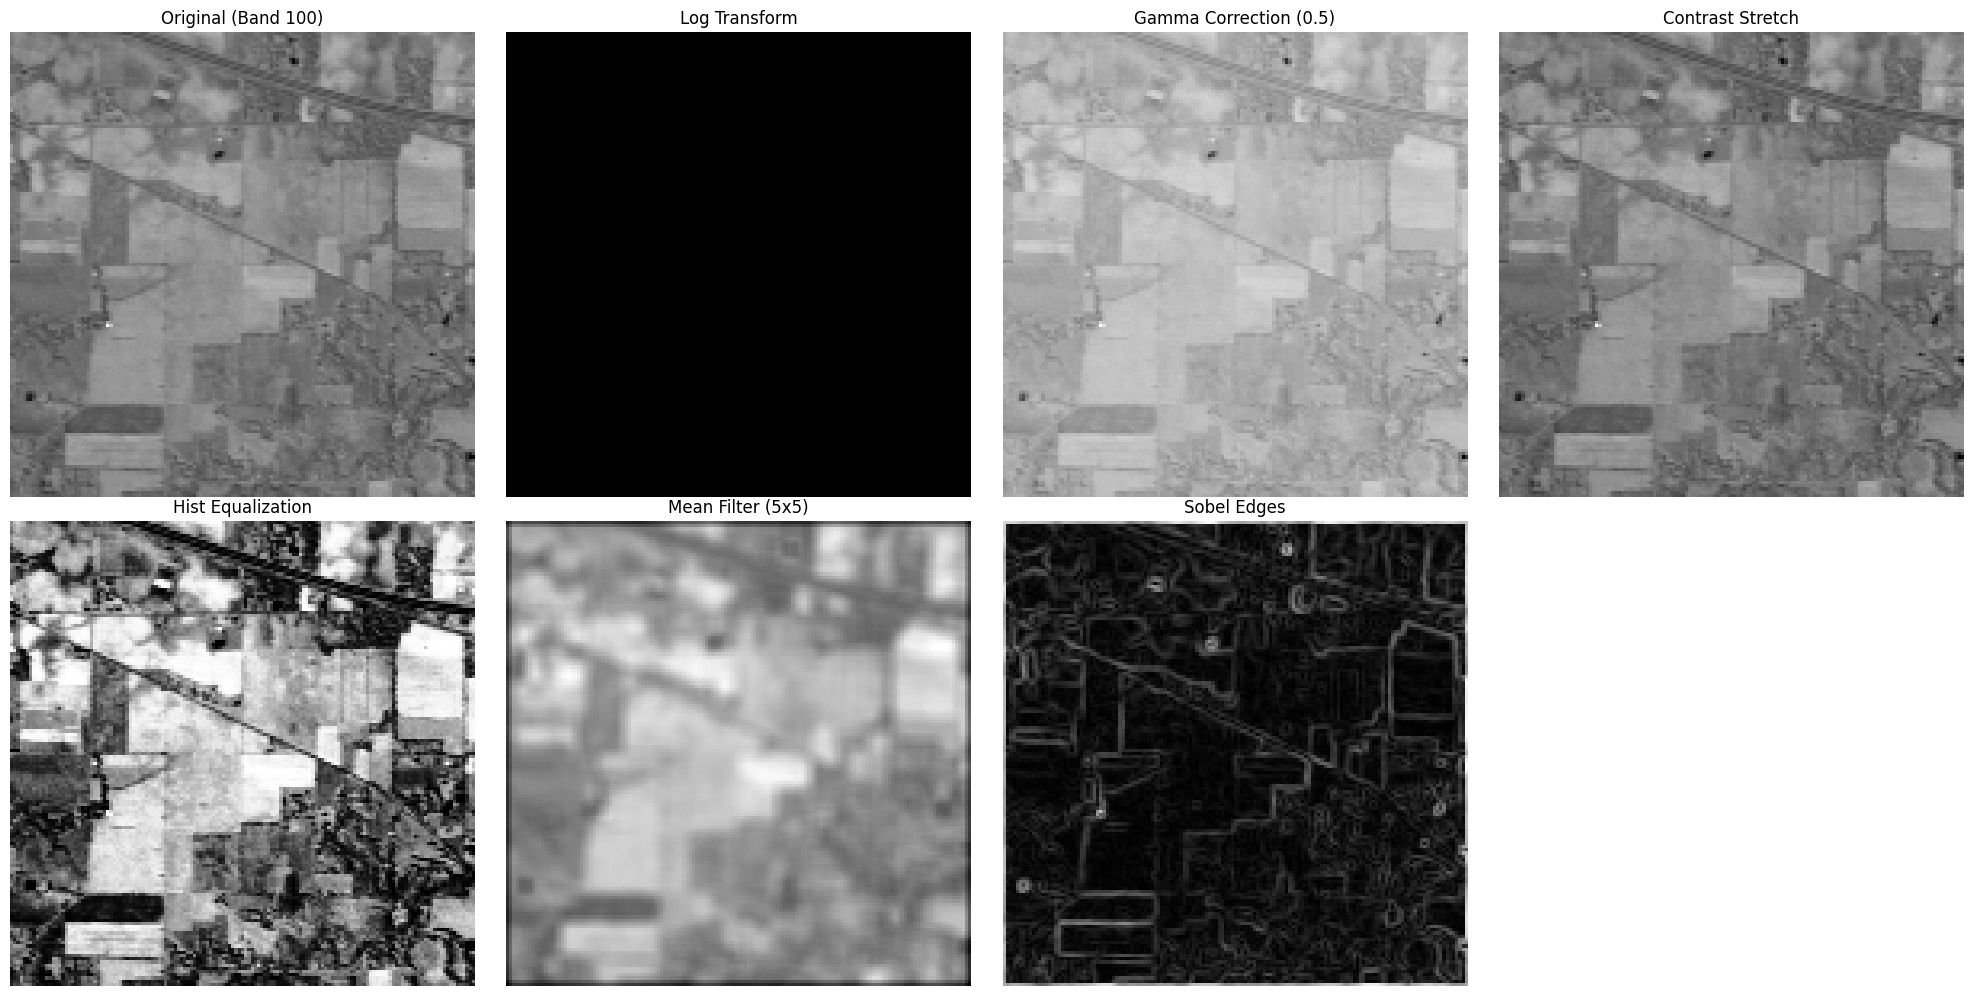

In [6]:
# Cell 6: Run Pipeline and Display Results

if hsi_cube is not None:
    print("Processing images... this might take a few seconds for convolution.")

    # 1. Run Algorithms
    img_log = log_transform(original_img)
    img_gamma = gamma_correction(original_img, gamma=0.5) # Gamma < 1 to brighten
    img_contrast = contrast_stretching(original_img)
    img_hist = histogram_equalization(original_img)

    # Use contrast stretched image for blur so we can see effect better
    img_mean = mean_filter(img_contrast, size=5)

    img_sobel = sobel_edge_detection(original_img)

    # 2. Visualization
    results = [original_img, img_log, img_gamma, img_contrast, img_hist, img_mean, img_sobel]
    titles = ['Original (Band 100)', 'Log Transform', 'Gamma Correction (0.5)',
              'Contrast Stretch', 'Hist Equalization', 'Mean Filter (5x5)', 'Sobel Edges']

    plt.figure(figsize=(20, 10))
    for i in range(len(results)):
        plt.subplot(2, 4, i+1)
        plt.imshow(results[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()